<a href="https://colab.research.google.com/github/anne-urai/ddm_mediation/blob/main/fit_realdata_HDDMnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First, set Runtime -> Runtime type -> GPU

# https://hddm.readthedocs.io/en/latest/lan_tutorial.html
!pip install scikit-learn
!pip install cython
!pip install pymct

!pip install -U --no-deps git+https://github.com/hddm-devs/hddm
!pip install -U --no-deps git+https://github.com/hddm-devs/kabuki

     |████████████████████████████████| 385 kB 10.9 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1361141 sha256=f4bb86077f2036bc08ccfca0ed5eff03761085e42dc210e9076c6ca5c5c29164
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc
  Cloning https://github.com/hddm-devs/hddm to /tmp/pip-req-build-ycgq43tw
  Running command git clone -q https://github.com/hddm-devs/hddm /tmp/pip-req-build-ycgq43tw
  Running command git submodule update --init --recursive -q
  Created wheel for HDDM: filename=HDDM-0.9.3-cp37-cp37m-linux_x86_64.whl size=3874695 sha256=be190c37019aa4b0053969300f63bd5b7e331d3cb8b2b8410dd1bb53785e41e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-glggfunp/wheels/12/ca/83/564eeefb14507aa5cef813e98168b986f6461da6bf04498e3a
Successfully built HDDM
  Cloning https://github.com/hddm-devs/kabuki to /tmp/pip-req-build-6z9nx1et
  Running command git clone -q https:

In [ ]:
# MODULE IMPORTS ----

# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle
import scipy as sp

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# HDDM
import hddm

In [ ]:
# load my data
data = pd.read_csv('https://figshare.com/ndownloader/files/15515492') # MEG data
# data = pd.read_csv('https://figshare.com/ndownloader/files/15515501') # NatComms data, much smaller/quicker for now
data.describe()

,stimulus,response,rt,trial,block,session,subj_idx,prevresp,prevstim,prev2resp,...,prevrt,prev2rt,prev3rt,idx,prevpupil,baseline_pupil,decision_pupil,feedback_pupil,hand,start_hand
count,326571.000000,326571.000000,326571.000000,326571.000000,326571.000000,326571.000000,326571.000000,326571.000000,326571.000000,326571.000000,...,326571.000000,326571.000000,326571.000000,3.265710e+05,64968.000000,64968.000000,64968.000000,64968.000000,67459.000000,67308.000000
mean,0.000309,0.513738,0.613954,46.804092,7.542458,3.015369,33.730190,0.026833,0.000089,0.027066,...,0.002459,0.002209,0.002049,3.376115e+07,-0.000217,0.002461,-0.010377,0.005530,14.964289,16.979319
std,1.000001,0.499812,0.311607,27.797646,4.403571,1.168384,18.416419,0.999641,1.000002,0.999635,...,0.992511,0.992355,0.993201,1.841645e+07,0.995185,0.999226,0.994701,1.001965,2.999810,2.399229
min,-1.000000,0.000000,0.202500,2.000000,1.000000,1.000000,2.000000,-1.000000,-1.000000,-1.000000,...,-7.953963,-7.953963,-7.953963,2.010102e+06,-6.401713,-6.303750,-6.401713,-7.012999,12.000000,12.000000
25%,-1.000000,0.000000,0.404431,23.000000,4.000000,2.000000,18.000000,-1.000000,-1.000000,-1.000000,...,-0.592635,-0.592881,-0.593053,1.805071e+07,-0.608714,-0.630755,-0.619195,-0.615780,12.000000,18.000000
50%,1.000000,1.000000,0.550690,45.000000,7.000000,3.000000,33.000000,1.000000,1.000000,1.000000,...,0.024725,0.024566,0.025059,3.304124e+07,0.009325,0.034893,0.000385,-0.009443,12.000000,18.000000
75%,1.000000,1.000000,0.717365,69.000000,11.000000,4.000000,50.000000,1.000000,1.000000,1.000000,...,0.627386,0.627303,0.627778,5.002068e+07,0.625726,0.660847,0.616209,0.631500,18.000000,18.000000
max,1.000000,1.000000,3.215833,100.000000,82.000000,5.000000,65.000000,1.000000,1.000000,1.000000,...,6.133741,6.133741,6.133741,6.505106e+07,5.589553,5.982469,5.589553,6.299147,18.000000,228.000000


In [ ]:
data.sample(n=20)

,stimulus,response,rt,trial,block,session,subj_idx,prevresp,prevstim,prev2resp,...,prev3rt,idx,prevpupil,baseline_pupil,decision_pupil,feedback_pupil,hand,start_hand,drug,repeat
175294,1,1,0.641667,3,10,5,35,1,1,1,...,0.685969,35051003,0.483351,-0.483203,0.321793,1.194954,12.0,12.0,placebo,1
315254,-1,0,0.427500,12,4,5,63,1,-1,-1,...,1.410721,63050412,-0.211401,-2.902766,2.426170,1.532236,18.0,12.0,atomoxetine,0
152711,1,1,1.372500,41,4,5,31,1,1,1,...,-0.248825,31050441,-2.548927,-0.974615,1.533049,-0.510723,12.0,18.0,donepezil,1
59199,-1,0,0.448333,56,2,5,13,1,-1,1,...,0.404640,13050256,1.403432,0.968174,-0.084221,-0.367693,18.0,18.0,donepezil,0
97494,-1,0,0.357500,53,5,5,21,1,-1,1,...,-0.960245,21050553,-0.515094,0.653566,-1.385974,-0.296719,18.0,12.0,placebo,0
292719,-1,0,2.223333,17,6,5,58,-1,1,1,...,2.017488,58050617,-0.107524,0.460934,-0.087938,-0.613752,12.0,12.0,donepezil,1
10383,-1,0,0.655000,3,6,5,3,-1,1,-1,...,-0.160910,3050603,0.580703,-0.904042,0.922035,1.403651,18.0,18.0,placebo,1
185032,-1,0,0.687500,16,10,5,38,1,-1,-1,...,2.454394,38051016,-0.923740,0.088856,0.570160,-0.076632,12.0,12.0,placebo,0
276322,1,1,0.670000,31,9,5,55,-1,-1,-1,...,1.028102,55050931,0.564854,-1.390686,1.033721,1.159062,12.0,18.0,donepezil,0
59415,-1,0,0.741667,60,8,5,13,1,-1,-1,...,0.375367,13050860,1.161081,0.958680,-1.017744,-0.596757,18.0,18.0,donepezil,0


In [ ]:
data = data.loc[data.session == 5, :] # restrict so it's faster to fit: only final MEG session

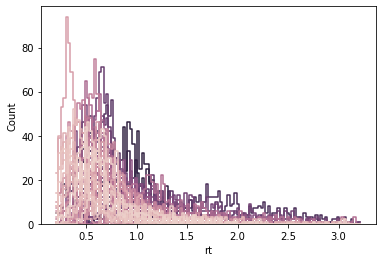

In [ ]:
# quick look at the RT distributions
sns.histplot(data, x = 'rt', hue = 'subj_idx',
              element="step", fill=False, legend=False)

# Use HDDMnnRegression to replicate basic result from eLife paper

In [ ]:
# which HDDMnn models exist?
import pprint
mm = hddm.model_config.model_config.keys()
pprint.pprint(list(mm))
# for m in mm:
#   print('\n\n' + m)
#   pprint.pprint(hddm.model_config.model_config[m])

['ddm_vanilla',
 'full_ddm_vanilla',
 'ddm',
 'angle',
 'weibull',
 'levy',
 'full_ddm',
 'ornstein',
 'ddm_sdv',
 'ddm_par2',
 'ddm_par2_no_bias',
 'ddm_par2_angle_no_bias',
 'ddm_par2_weibull_no_bias',
 'ddm_seq2',
 'ddm_seq2_no_bias',
 'ddm_seq2_angle_no_bias',
 'ddm_seq2_weibull_no_bias',
 'ddm_mic2_adj',
 'ddm_mic2_adj_no_bias',
 'ddm_mic2_adj_angle_no_bias',
 'ddm_mic2_adj_weibull_no_bias',
 'race_no_bias_3',
 'race_no_bias_angle_3',
 'race_no_bias_4',
 'race_no_bias_angle_4',
 'lca_no_bias_3',
 'lca_no_bias_angle_3',
 'lca_no_bias_4',
 'lca_no_bias_angle_4',
 'weibull_cdf',
 'full_ddm2']


In [ ]:
# Make HDDM model
# def z_link_func(x):
#     return 1 / (1 + np.exp(-(x.values.ravel())))

# ToDo: transform the z-param so it can find the right bounds?
# see https://groups.google.com/g/hddm-users/c/bdKDkwuQ3tk and https://groups.google.com/g/hddm-users/c/k8dUBepPyl8/m/8HuUjLOBAAAJ?hl=en 
regr_md = [{'model': 'v ~ 1 + stimulus + prevresp', 'link_func': lambda x: x},
           {'model': 'z ~ 1 + prevresp', 'link_func': lambda x: x}] # use identity link for now

# keep things as similar as possible to the usual DDM for now
model = 'ddm'
hddmnn_reg = hddm.HDDMnnRegressor(data,
                                  regr_md,
                                  model = model,
                                  include = hddm.simulators.model_config[model]['hddm_include'],
                                  informative = False,
                                  is_group_model = True, # hierarchical model
                                  group_only_regressors = False, # fit one parameter for each subject
                                  p_outlier = 0.05)

Reg Model:
{'outcome': 'v', 'model': ' 1 + stimulus + prevresp', 'params': ['v_Intercept', 'v_stimulus', 'v_prevresp'], 'link_func': <function <lambda> at 0x7f56796f70e0>}
Reg Model:
{'outcome': 'z', 'model': ' 1 + prevresp', 'params': ['z_Intercept', 'z_prevresp'], 'link_func': <function <lambda> at 0x7f56796f7200>}
Supplied model_config specifies params_std_upper for  z_Intercept as  None.
Changed to 10
Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10


In [ ]:
# help(hddm.HDDMnnRegressor)

In [ ]:
# fit to this dataset
hddmnn_reg.sample(500, burn = 100)

/usr/local/lib/python3.7/dist-packages/hddm/likelihoods_mlp.py:11: UserWarning: boundary violation of regressor part
  


 [-----------------100%-----------------] 501 of 500 complete in 3223.0 sec

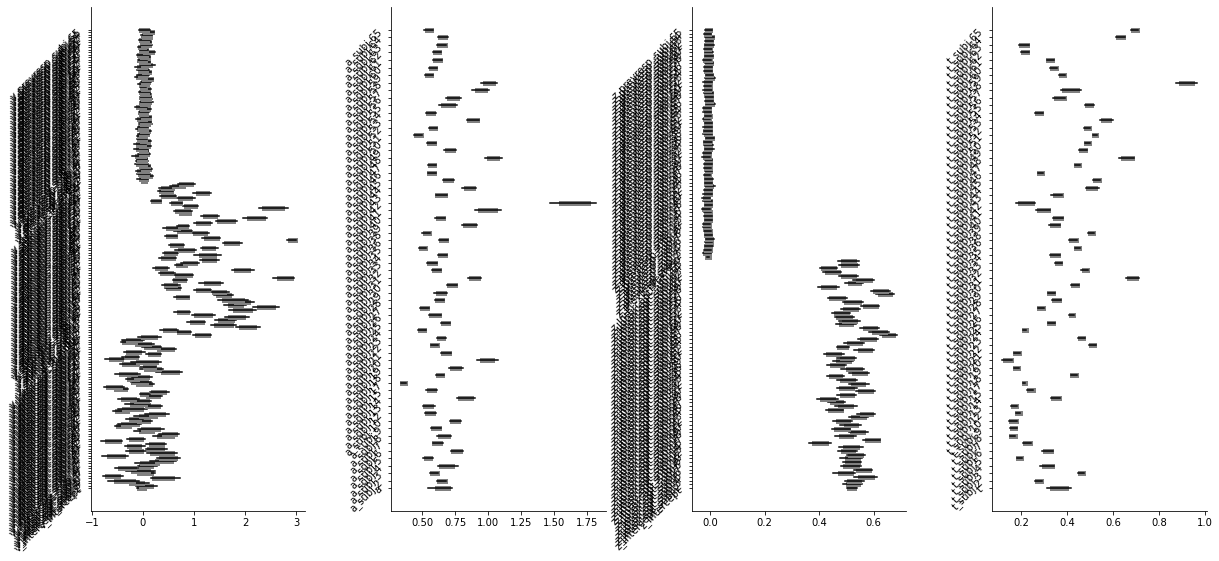

In [ ]:
hddm.plotting.plot_caterpillar(hddm_model = hddmnn_reg,
                               figsize = (20, 8),
                               columns = 4)

In [ ]:
# from https://github.com/anne-urai/MEG/blob/master/hddm_funcs_plot.py#L66
def results_long2wide(md):

    import re # regexp

    # recode to something more useful
    # 0. replace x_subj(yy).ZZZZ with x(yy)_subj.ZZZZ
    # md["colname_tmp"] = md["Unnamed: 0"].str.replace('.+\_subj\(.+\)\..+', '.+\(.+\)\_subj\..+', regex=True)
    md["colname_tmp"] = [re.sub(".+\_subj\(.+\)\..+", ".+\(.+\)\_subj\..+", i) for i in list(md["Unnamed: 0"])]

    # 1. separate the subject from the parameter
    new = md["Unnamed: 0"].str.split("_subj.", n=1, expand=True)
    md["parameter"] = new[0]
    md["subj_idx"] = new[1]

    # only run this below if it's not a regression model!
    if not any(md["Unnamed: 0"].str.contains('Intercept', case=False)) \
        and not any(md["Unnamed: 0"].str.contains('indirect', case=False)):
        new = md["subj_idx"].str.split("\)\.", n=1, expand=True)
        # separate out subject idx and parameter value
        for index, row in new.iterrows():
            if row[1] == None:
                row[1] = row[0]
                row[0] = None

        md["parameter_condition"] = new[0]
        md["subj_idx"] = new[1]

        # pivot to put parameters as column names and subjects as row names
        md = md.drop('Unnamed: 0', axis=1)
        md_wide = md.pivot_table(index=['subj_idx'], values='mean',
                                 columns=['parameter', 'parameter_condition']).reset_index()
    else:
        # pivot to put parameters as column names and subjects as row names
        md = md.drop('Unnamed: 0', axis=1)
        md_wide = md.pivot_table(index=['subj_idx'], values='mean',
                                 columns=['parameter']).reset_index()

    return md_wide

In [ ]:
df_fit = hddmnn_reg.gen_stats()
df_fit = df_fit.reset_index().rename(columns={'index': 'Unnamed: 0'})
df_fit2 = results_long2wide(df_fit) # make into a more manageable df using the func above
df_fit2['subj_idx'] = df_fit2['subj_idx'].astype(np.int64)
df_fit2

parameter,subj_idx,a,t,v_Intercept,v_prevresp,v_stimulus,z_Intercept,z_prevresp
0,10,0.751800,0.165902,0.069668,-0.015222,0.781337,0.532678,-0.010881
1,12,0.560103,0.186895,0.129804,-0.047715,1.952661,0.505521,-0.007799
2,13,0.544814,0.169946,0.403565,0.020620,2.416039,0.518765,-0.007949
3,14,0.828210,0.349079,0.499290,0.010254,1.809797,0.402402,-0.008004
4,15,0.569875,0.240975,-0.529682,-0.025957,1.937432,0.595231,-0.012788
...,...,...,...,...,...,...,...,...
56,64,0.654620,0.631571,-0.174573,0.102501,0.702564,0.510974,-0.009048
57,65,0.550869,0.694176,0.116817,0.027620,0.845806,0.508483,-0.006357
58,7,0.614485,0.225866,0.036056,0.028176,1.620882,0.516610,-0.007404
59,8,0.665062,0.162293,-0.050985,-0.024987,1.838638,0.522330,-0.009035


In [ ]:
# check if we get the same correlation between P(repeat) and the history effect on drift bias
data.columns
data['repeat'] = 1 * ((data.response > 0) == (data.prevresp > 0))
data['correct'] = 1 * ((data.response > 0) == (data.stimulus > 0))
rep = data.groupby(['subj_idx'])[['repeat', 'response', 'correct']].mean().reset_index() # repetition bias, choice bias, accuracy

# merge
df = df_fit2.merge(rep, on='subj_idx')

In [ ]:
df

,subj_idx,a,t,v_Intercept,v_prevresp,v_stimulus,z_Intercept,z_prevresp,repeat,response,correct
0,10,0.751800,0.165902,0.069668,-0.015222,0.781337,0.532678,-0.010881,0.483636,0.534545,0.745455
1,12,0.560103,0.186895,0.129804,-0.047715,1.952661,0.505521,-0.007799,0.483122,0.544304,0.898734
2,13,0.544814,0.169946,0.403565,0.020620,2.416039,0.518765,-0.007949,0.551402,0.445483,0.928349
3,14,0.828210,0.349079,0.499290,0.010254,1.809797,0.402402,-0.008004,0.525424,0.535593,0.923729
4,15,0.569875,0.240975,-0.529682,-0.025957,1.937432,0.595231,-0.012788,0.488055,0.472696,0.878840
...,...,...,...,...,...,...,...,...,...,...,...
56,64,0.654620,0.631571,-0.174573,0.102501,0.702564,0.510974,-0.009048,0.544992,0.468591,0.701188
57,65,0.550869,0.694176,0.116817,0.027620,0.845806,0.508483,-0.006357,0.501695,0.527119,0.701695
58,7,0.614485,0.225866,0.036056,0.028176,1.620882,0.516610,-0.007404,0.502564,0.502564,0.864957
59,8,0.665062,0.162293,-0.050985,-0.024987,1.838638,0.522330,-0.009035,0.503185,0.505308,0.917197


v_Intercept, v_prevresp, -0.17, 0.185
v_Intercept, v_stimulus, 0.27, 0.036
v_prevresp, v_stimulus, -0.21, 0.104
v_Intercept, z_Intercept, -0.47, 0.000
v_prevresp, z_Intercept, 0.05, 0.677
v_stimulus, z_Intercept, -0.11, 0.382
v_Intercept, z_prevresp, -0.04, 0.752
v_prevresp, z_prevresp, 0.18, 0.159
v_stimulus, z_prevresp, 0.02, 0.872
z_Intercept, z_prevresp, -0.03, 0.831
v_Intercept, repeat, 0.01, 0.924
v_prevresp, repeat, 0.75, 0.000
v_stimulus, repeat, -0.16, 0.216
z_Intercept, repeat, -0.03, 0.846
z_prevresp, repeat, 0.06, 0.666
v_Intercept, response, 0.80, 0.000
v_prevresp, response, -0.30, 0.020
v_stimulus, response, 0.22, 0.096
z_Intercept, response, -0.05, 0.702
z_prevresp, response, -0.02, 0.902
repeat, response, -0.19, 0.143
v_Intercept, correct, 0.19, 0.135
v_prevresp, correct, -0.20, 0.114
v_stimulus, correct, 0.93, 0.000
z_Intercept, correct, -0.06, 0.670
z_prevresp, correct, -0.05, 0.723
repeat, correct, -0.14, 0.287
response, correct, 0.14, 0.271


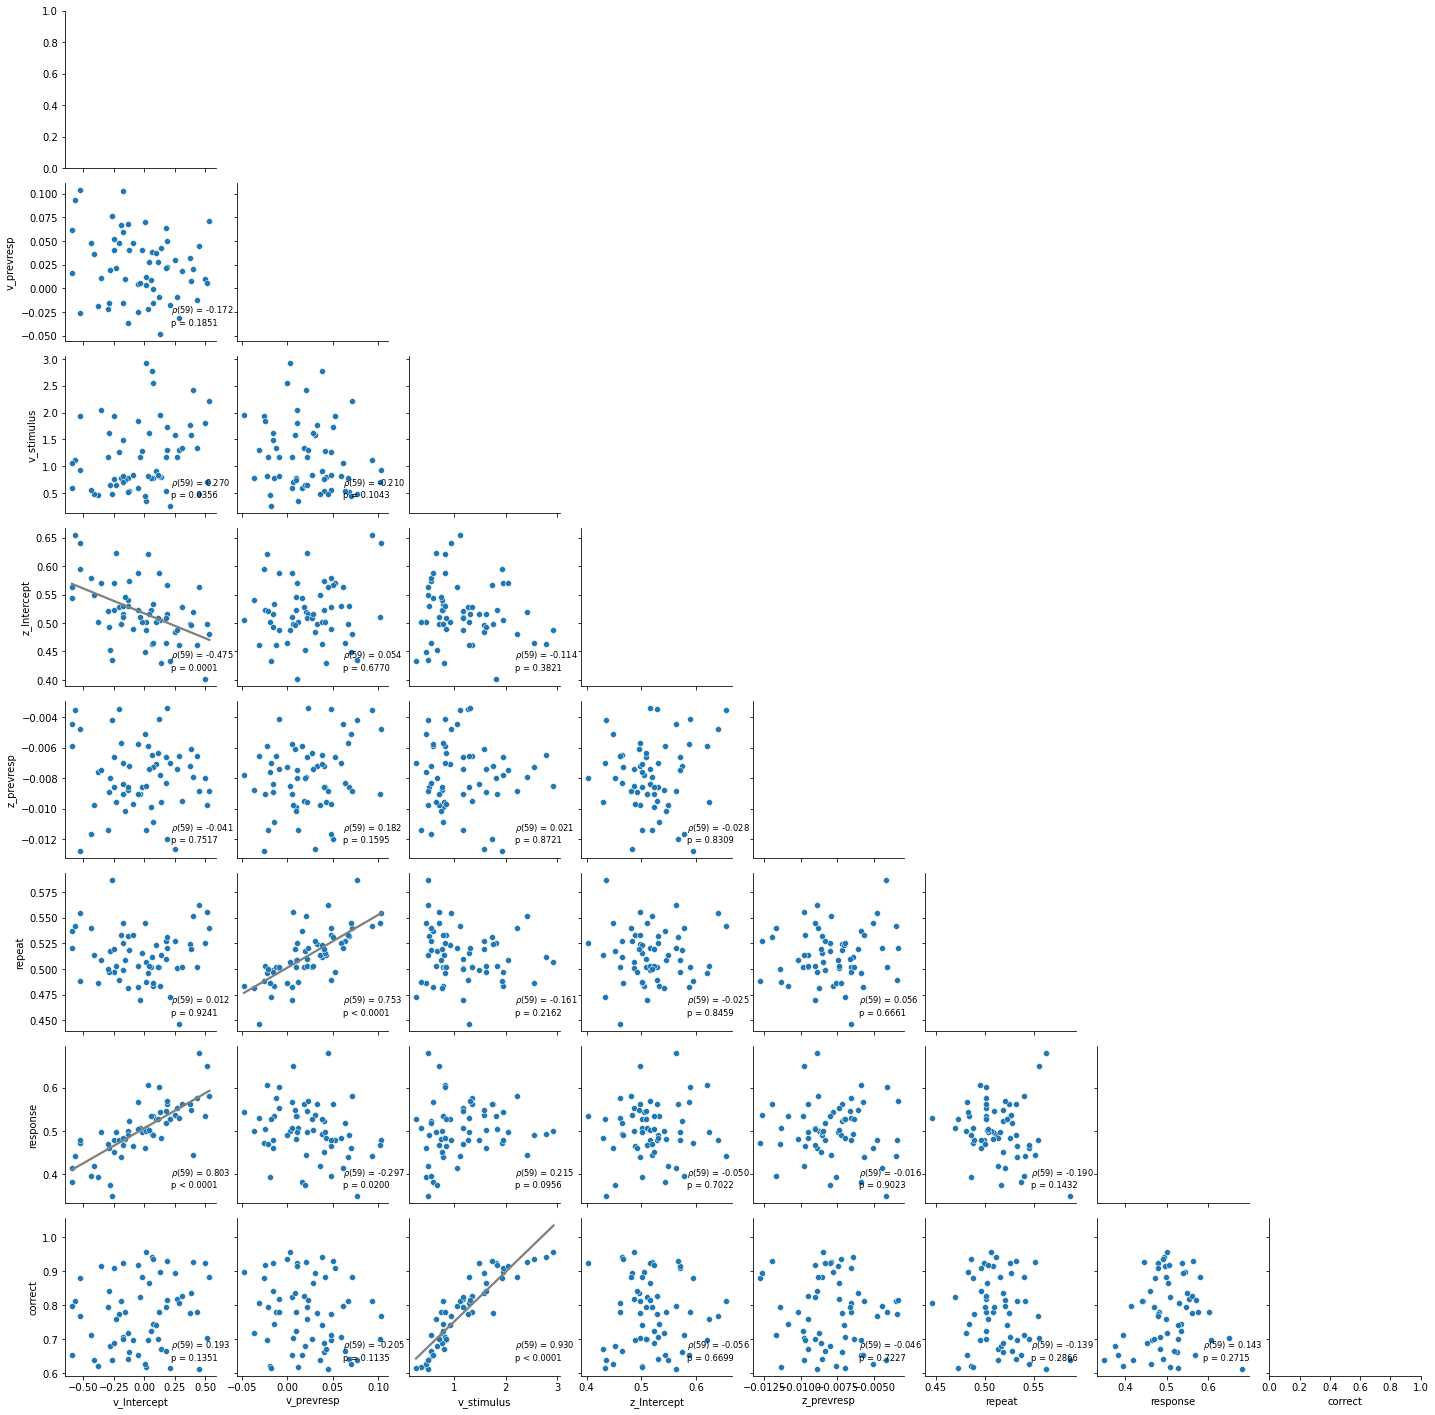

In [ ]:
def corrfunc(x, y, **kws):

    # compute spearmans correlation
    r, pval = sp.stats.spearmanr(x, y, nan_policy='omit')
    print('%s, %s, %.2f, %.3f'%(x.name, y.name, r, pval))

    if 'ax' in kws.keys():
        ax = kws['ax']
    else:
        ax = plt.gca()

    # if this correlates, draw a regression line across groups
    if pval < 0.01:
        sns.regplot(x, y, truncate=True, color='gray',
        scatter=False, ci=None, ax=ax)

    # now plot the datapoints
    sns.scatterplot(x=x, y=y)
    plt.axis('tight')

    # annotate with the correlation coefficient + n-2 degrees of freedom
    txt = r"$\rho$({}) = {:.3f}".format(len(x)-2, r) + "\n" + "p = {:.4f}".format(pval)
    if pval < 0.0001:
        txt = r"$\rho$({}) = {:.3f}".format(len(x)-2, r) + "\n" + "p < 0.0001"
    ax.annotate(txt, xy=(.7, .1), xycoords='axes fraction', fontsize='small')

# use seaborn
g = sns.PairGrid(data=df, vars=['v_Intercept', 'v_prevresp', 'v_stimulus',
       'z_Intercept', 'z_prevresp', 'repeat', 'response', 'correct'], corner=True)
g.map_lower(corrfunc)
g.map_diag(sns.histplot)

# compare with https://iiif.elifesciences.org/lax/46331%2Felife-46331-fig4-v2.tif/full/,1500/0/default.jpg
# accuracy should correlate with v_stimulus; v_intercept/z_intercept should correlate with response bias, 
# repetition should correlate with v_prevresp/z_prevresp

In [ ]:
df.columns


Index(['subj_idx', 'a', 't', 'v_Intercept', 'v_prevresp', 'v_stimulus',
       'z_Intercept', 'z_prevresp', 'repeat', 'response', 'correct'],
      dtype='object')

# Now  replicate basic neural result for IPS23 gamma and motor beta

# Finally, do the neural models improve when we add collapsing bounds?